In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

mnist = tf.keras.datasets.mnist 
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train.reshape(60000, 28, 28, 1)/255, x_test.reshape(10000, 28, 28, 1)/255
x_train, x_test = (x_train-1/2)*2, (x_test-1/2)*2
y_train, y_test = y_train.reshape(60000, 1), y_test.reshape(10000, 1)

def create_model_for_mnist():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(28, 28, 1)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (5, 5), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1024, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    return model
    
def print_prediction(model, x1):
    x1 = x1.reshape(1,28,28,1)
    p1 = model.predict(x1)
    l1 = np.argmax(p1)
    return l1, p1[0, l1]
    
def show_x_and_dx(x, dx, model):
    fig = plt.figure(figsize=(14,4))
    fig.add_subplot(1,3,1)
    pred, prob = print_prediction(model, x)
    plt.title(r"${\bf x},\quad pred({\bf x})=%d, \quad p=%.2f$"%(pred, prob))
    plt.imshow(((x_test[n]+1)/2).reshape(28, 28), cmap='gray', vmin=0, vmax=1)
    fig.add_subplot(1,3,2)
    plt.title(r"$\delta x$")
    plt.imshow(dx.numpy().reshape(28, 28)/2, cmap='gray', vmin=0, vmax=1)
    fig.add_subplot(1,3,3)
    pred, prob = print_prediction(model, x+delta_x.numpy())
    plt.title(r"${\bf x}+\delta x,\quad pred({\bf x} + \delta x)=%d, \quad p=%.2f$"%(pred, prob))
    plt.imshow(((x_test[n]+dx.numpy()+1)/2).reshape(28, 28), cmap='gray', vmin=0, vmax=1)
    plt.show()
    
def sigmoid(x):
    return 1/(1+np.exp(-x))

## 6-2. Adversarial examples

<font color="red">**注意：このノートにはバグがあるみたいで、正常に動作しません。近いうちに直したいと思っています…**</font>

### モデル保存の方法

教師あり深層学習、とくに画像認識では、${\bf x}$ が入ってきたときの、そのラベルについての条件付き確率

$$
p_w(\text{label}\mid {\bf x})
$$

をモデル化したと思えるのでした。これは例えば、MNISTデータ等で以下のように誤差関数

$$
l_w(y, {\bf x}) = \text{loss}_\text{softmax}\Big(y, p_w(\cdot \mid {\bf x})\Big)
$$

をSGDなどを用いて $w$ について小さくすることで達成したのでした。ここでもう一度モデルを訓練してみます。今まで**モデル保存**を説明してこなかったので、ついでに説明すると（色々やり方がありますが）一つの方法は、`model.save_weights('path')` とすることです：

In [244]:
model = create_model_for_mnist()
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model.fit(x_train, y_train, epochs=3, validation_data=(x_test, y_test))
model.save_weights('./checkpoints/my_checkpoint')

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 82s 1ms/sample - loss: 0.1184 - accuracy: 0.9634 - val_loss: 0.0341 - val_accuracy: 0.9885

これは同じように、一旦モデルインスタンスを作ったら、`model.load_weights('path')` で復元できます：

In [3]:
model = create_model_for_mnist()
model.load_weights('./checkpoints/my_checkpoint')

以下ではテストデータをランダムに選び、画像として表示し、その上に保存した訓練済みモデルのラベル予想 pred$({\bf x})$ と、その確率値 $p = p_w(\text{pred}({\bf x})\mid {\bf x})$ を表示します：

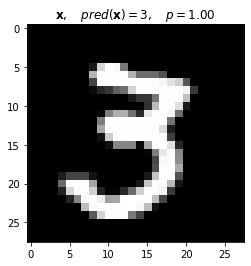

In [11]:
n = np.random.randint(len(y_test))
pred, prob = print_prediction(model, x_test[n])
plt.title(r"${\bf x},\quad pred({\bf x})=%d, \quad p=%.2f$"%(pred, prob))
plt.imshow(((x_test[n]+1)/2).reshape(28, 28), cmap='gray', vmin=0, vmax=1)
plt.show()

解釈性に難はあるものの、深層学習を用いた画像認識の能力が十分認識されはじめた頃、[arXiv:1312.6199](https://arxiv.org/abs/1312.6199) にて報告されたニューラルネットワークの性質の一つが、「訓練画像が同じであれば、それで訓練されたニューラルネットワークは共通のノイズに対して脆弱性を持つ」という性質で、そのような脆弱性を突いたノイズ入り画像を、今日では **敵対的イグザンプル(adversarial examples)** またはノイズを **敵対的摂動(adversarial perturbation)** などといい、社会実装などを踏まえて解くべき重要な問題になっています。

### 素朴なAdversarial examples
例えば、入力データ ${\bf x}$ を $y_\text{tricked}$ と認識させたい場合、摂動 $\delta {\bf x}$ は

$$
\delta{\bf x} = \arg \min_{{\bf r}} \Big( l_w(y_\text{tricked}, {\bf x}+ {\bf r}) + c |{\bf r}| \Big)
$$

を考えればよいでしょう。それぞれ、
* 1項目：$l_w(y_\text{tricked}, {\bf x}+ {\bf r})$ の最小化＝ノイズ ${\bf r}$ を調整して望むラベル $y_\text{tricked}$ との誤差を減らす
* 2項目：$c |{\bf r}|$の最小化＝あまりノイズが大きくなりすぎないようにする正則化項

を意味します。この他にも pred$({\bf x}+{\bf r}) = y_\text{tricked}$ を満たすような最小のノルムを持つ ${\bf r}$ を探すなど、様々な方法が考えられますが、実装面から上の問題を適当な $c$ と勾配降下法

$$
{\bf r} \leftarrow {\bf r} - \nabla_{\bf r} \Big( l_w(y_\text{tricked}, {\bf x}+ {\bf r}) + c |{\bf r}| \Big)
$$

で探してみます。以下で model, ${\bf x}, y_\text{tricked}$  を指定して $\delta {\bf x}$ の近似が出てくる関数を実装してみました：




In [12]:
def naive_adversarial_perturbation_for(model, x=None, y_tricked=None, iters=500, c=0.1):
    opt = tf.keras.optimizers.SGD()
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    dist_fn = tf.keras.losses.MeanSquaredError()
    x = tf.constant(x.reshape(1, 28, 28, 1).astype(np.float32))
    y = tf.constant(np.array([[y_tricked]]))
    init = tf.random_normal_initializer()
    x_plus_r = tf.Variable(initial_value=x+np.random.normal(0,.05, (1,28,28,1)), trainable=True)
    for _ in range(iters):
        with tf.GradientTape() as tape:
            tape.watch(x_plus_r)
            loss = loss_fn(y, model(x_plus_r)) + c*dist_fn(x, x_plus_r)
        grads = tape.gradient(loss, x_plus_r)
        opt.apply_gradients(([grads, x_plus_r], ))
        # ピクセル値 \in [-1, 1] なので、はみ出たら±1で切る（クリップする）
        x_plus_r = tf.Variable(tf.clip_by_value(x_plus_r, clip_value_min=-1, clip_value_max=1)) 
    return x_plus_r - x

実際に運用してみます：

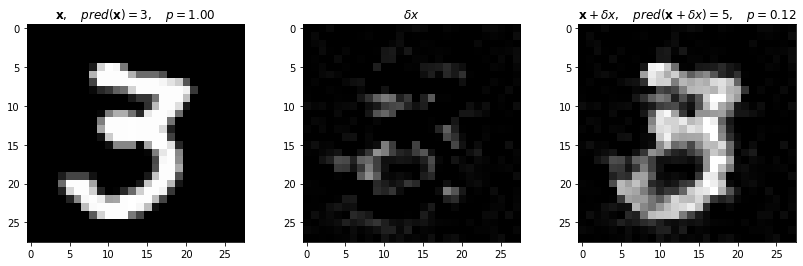

CPU times: user 6.69 s, sys: 581 ms, total: 7.27 s
Wall time: 6.34 s


In [13]:
%%time
delta_x = naive_adversarial_perturbation_for(model, x=x_test[n], y_tricked=2, iters=300, c=0.001)
show_x_and_dx(x_test[n], delta_x, model)

あまり上手く狙ったとおりに $y_\text{tricked}$ と認識するような摂動は作れませんが、**人の目の判断と明らかに異なる結果を返す** ようにできるのがわかると思います。ただし、現段階ではいくつか対処のしようがあります：
1. よく見るとモデルの条件付き確率 $p=p_w\Big(\text{pred}({\bf x}+\delta{\bf x})\mid {\bf x}+\delta{\bf x} \Big) \approx 0.1$ と小さい（元のモデル出力はほぼ1）
2. 見た目でも少しノイズが見えるので、それで対処できる
3. そもそも勾配更新に時間がかかるので、大規模な攻撃は行えない（ような気がする）

などが挙げられます。しかし、もっと良い敵対的摂動の構成が可能なのです。

### Fast Gradient Sign Method (FGSM)
まず初めに紹介するのは [arXiv:1412.6572](https://arxiv.org/abs/1412.6572) で提案された手法で、これは上に挙げた弱点の1,3を緩和できます。特に摂動を見つけるのに必要な時間が大幅に削減される方法で、場合によっては **1回だけ勾配更新する** だけで敵対的摂動を見つけられる手法です。これは勾配の「符号」のみを用いるため、Fast Gradient Sign Method (FGSM)と呼ばれます。

これは以下で定義されるアップデートを用います：

$$
{\bf r} \leftarrow {\bf r} - \epsilon \cdot \text{sign}\Big[ \nabla_{\bf x + r} \Big( l_w(y_\text{tricked}, {\bf x}+ {\bf r})  \Big) \Big]
$$

実装は以下です：

In [14]:
def FGSM_like(model, x=None, y_tricked=None, epsilon=0.01, iters=10):
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    x = tf.constant(x.reshape(1, 28, 28, 1).astype(np.float32))
    y = tf.constant(np.array([[y_tricked]]))
    x_plus_r = tf.Variable(initial_value=x)
    for _ in range(iters):
        with tf.GradientTape() as tape:
            tape.watch(x_plus_r)
            loss = loss_fn(y, model(x_plus_r)) 
            #print(loss)
        grads = tape.gradient(loss, x_plus_r) 
        x_plus_r = tf.Variable(tf.clip_by_value(x_plus_r-epsilon*tf.sign(grads)/iters, clip_value_min=-1, clip_value_max=1))
    return x_plus_r - x

実際に使ってみると、素朴な方法よりも高速で、摂動を入れたネットワーク出力値も大きくなるようにチューニングできるのがわかります：

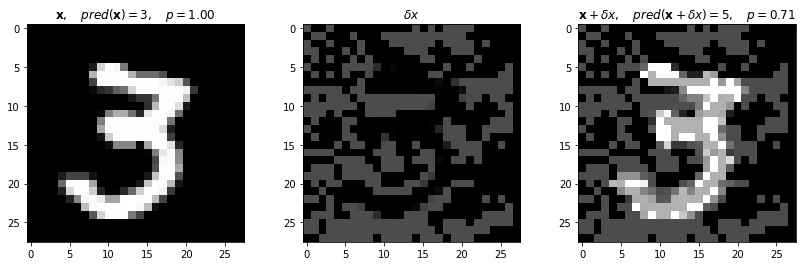

CPU times: user 677 ms, sys: 21.8 ms, total: 699 ms
Wall time: 688 ms


In [16]:
%%time
delta_x = FGSM_like(model, x=x_test[n], y_tricked=2, epsilon=.6, iters=1)
show_x_and_dx(x_test[n], delta_x, model)

なぜこの方法で上手くいくか、上に挙げた提案論文ではニューラルネットワークに頻繁に用いられるReLUの性質に着目しています。ネットワークをReLUで構成した場合、ネットワークは ${\bf x}$ 空間では飛び飛びに線形（区分線形）関数になるため、入力 ${\bf x}$ の近傍は線形関数で近似しても良いでしょう。すると、最終のsoftmax出力までは線形なので

$$
p_w(y\mid {\bf x}) = \sigma_\text{softmax} (W {\bf x} + {\bf b})
$$

とかけるはずです。ここでは更に簡単のため論文に従い 2値分類を考え、softmaxがsigmoidで書ける場合を考えます。すると

$$
p_w(y=1\mid {\bf x}) = \sigma({\bf w} \cdot {\bf x} + b),\quad
p_w(y=0\mid {\bf x}) = 1- \sigma({\bf w} \cdot {\bf x} + b)
$$

となります。sigmoid関数の微分の性質：$\sigma ' = \sigma (1 -\sigma)$ を使うと、交差エントロピー誤差$l$の ${\bf x}$ 微分は

$$
\left. \begin{array}{ll}
\nabla_{\bf x}l_w (y \mid {\bf x}) &= \nabla_{\bf x} \Big(-y\log \sigma({\bf w} \cdot {\bf x} + b) - (1-y)\log [ 1- \sigma({\bf w} \cdot {\bf x} + b) ] \Big)
\\ &= -y \frac{\sigma'}{\sigma} {\bf w} -(1-y) \frac{-\sigma'}{1- \sigma}{\bf w}
\\ & = - y (1- \sigma) {\bf w}+(1-y) \sigma{\bf w}
\\ & = (\sigma - y) {\bf w} 
\\ & = \Big( p_w(y=1 \mid {\bf x}) - y \Big) {\bf w}
\end{array} \right.
$$

となるのがわかります。








ここで、実際の答えは $y=1$ だとすると、誤認識は$y = y_\text{tricked} = 0$ に対応します。このとき

$$
\nabla_{\bf x}l_w (y_\text{tricked} \mid {\bf x}) = \underbrace{\Big( p_w(y=1 \mid {\bf x}) - 0 \Big)}_{=:c\ >\ 0} {\bf w} 
$$

がわかります。従って1回更新だと

$$
\delta {\bf x} = - \epsilon \cdot \text{sign}\nabla_{\bf x}l_w (y_\text{tricked} \mid {\bf x}) = - \epsilon \cdot \text{sign}({\bf w})
$$

となるのがわかります。すると摂動した入力に対する訓練済みネットワークの出力は

$$
p_w(y=1 \mid {\bf x} + \delta {\bf x}) = \sigma \Big({\bf w} \cdot ({\bf x}+\delta{\bf x}) + b \Big) = \sigma({\bf w} \cdot{\bf x} + b - \epsilon  \|{\bf w}\|_1 )
$$

となるのがわかります。ここで $\|{\bf w}\|_1$ は成分毎の絶対値の和（L1ノルム）です。このL1ノルムですが、パラメータ数が大きいと次元の呪い効果で大きな値を持つようになります。ここで $dim({\bf w})=$画像空間次元なので、今の場合$28^2 = 784$ となります。この値は画像が細かくなるにつれて更に顕著に大きくなりますが、そうすると元のsigmoid関数の中身が極端に負の値になるわけですが、それは $y=1$ と正しく認識される確率が

In [31]:
sigmoid(-10)

4.5397868702434395e-05

のように極端に小さくなることを意味するというわけです。

### Jacobian-Based Saliency Map Approach (JSMA)
FGSMはとても高速でしたが、狙ったとおり誤認識する場合とそうでもない場合があります。また、全体にノイズが乗るため判別しやすい問題（？）もありますが、[arXiv:1511.07528](https://arxiv.org/abs/1511.07528) の手法、Jacobian-Based Saliency Map Approach (JSMA)を用いるとかなり安定した敵対的摂動をかけることが可能になります。ここでは論文で述べられているアルゴリズムの簡単版を説明します。

まず、JSMAでは誤差関数を用いることを辞めます。それよりも、誤認識させるのならば、ニューラルネットワークの出力を直接見て判断すれば良いというわけです。すなわち、
* $\frac{\partial p_w(y_\text{tricked}\mid{\bf x})}{\partial x_i}$ が大きい ${\bf x} = (x_i)_{i=1,2, \dots, \# pixels\times\#channels}$ だけ変更すれば良い

というのが大雑把な考え方です。以下では、勾配の値が大きい順に順にピクセル値上限の半分の摂動を加えるiterationによるアルゴリズムです：



In [17]:
def JSMA_like(model, x=None, y_tricked=None, theta=1, iters=10):
    x = tf.constant(x.reshape(1, 28, 28, 1).astype(np.float32))
    x_plus_r = tf.Variable(initial_value=x)
    choosed = []
    for _ in range(iters):
        with tf.GradientTape() as tape:
            tape.watch(x_plus_r)
            loss = model(x_plus_r)[0, y_tricked]
            #print(loss)
        grads = tape.gradient(loss, x_plus_r).numpy().reshape(28**2)
        while True:
            i = np.argmax(grads)
            if i in choosed:
                grads[i] = -10**10 # この辺かなり雑ですが、一回選んだピクセルが選ばれないようにしています。
            else:
                break
        dx = np.zeros(28*28)
        dx[i] += 1
        dx= dx.reshape(1,28,28,1)
        #print("w")
        x_plus_r = tf.Variable(tf.clip_by_value(x_plus_r+ theta*dx, clip_value_min=-1, clip_value_max=1))
        choosed.append(i)
        #x_ = tf.Variable(tf.clip_by_value(x_+epsilon*(1+tf.sign(grads))/iters, clip_value_min=-1, clip_value_max=1))
    return x_plus_r - x

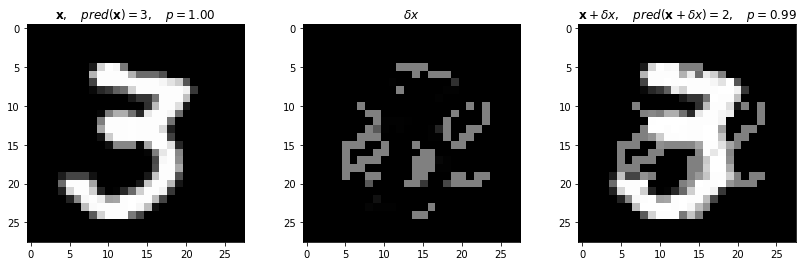

CPU times: user 2.08 s, sys: 226 ms, total: 2.3 s
Wall time: 1.96 s


In [19]:
%%time
delta_x = JSMA_like(model, x=x_test[n], y_tricked=2, iters=100, theta=1.)
show_x_and_dx(x_test[n], delta_x, model)

このように、点の数を増やすとほぼ100%、狙ったラベルに認識させることが可能です。上のように「点を加える」のではなく、「うまく点を消す」ことでも狙ったラベルに認識させられます。詳しくは原論文を見てください。

### 敵対的学習による正則化効果
このような、人間の目で（今回の例だと贔屓目に）見ると正しく判別できるデータをニューラルネットワークが誤認識するのは、いわばニューラルネットワークが訓練で獲得した入力-出力のランドスケープの「秘孔を突かれた」ような状態です。そこで、秘孔をなくす為にもう一度、敵対的イグザンプル込で、これをきちんと識別するように訓練する、**敵対的学習(adversarial training)** をすると、敵対的摂動に対して**強固(robust)** なネットワークが作れると期待できます。うまくやると汎化性能も上げられるようです。

しかしながら、敵対的摂動に対するロバスト性を高めたネットワークといっても、で紹介したアルゴリズムを用いて画像に $\delta {\bf x}$ を加えることはできます。自然な疑問は、ロバスト性が上がったネットワークに $\delta {\bf x}$ を加えるとどうなるか？というのがありますが、 [arXiv:1906.09453](https://arxiv.org/abs/1906.09453) では「ロバスト性を高めたネットワークに対する敵対的摂動は**意味のある画像生成**を達成する」と実験で示しており、非常に興味深いです。